In [1]:
import numpy as np
import ROOT as r
import sys,math,array,os
import matplotlib.pyplot as plt
r.gROOT.Macro(os.path.expanduser('~/.rootlogon_nystyle.C'))

Welcome to JupyROOT 6.12/07


0L

# load bunch of numpy arrays

In [29]:
sigaeloss_bb  = np.load('sigaeloss_numsig_100_bb.npy')
sigaeloss_bkg = np.load('sigaeloss_numsig_100_bkg.npy')
mass_bb       = np.load('mass_numsig_100.npy')
mass_bkg      = np.load('mass_bkg.npy')
bkgaeloss_bb  = np.load('bkgaeloss_numsig_100.npy')
bkgaeloss_bkg = np.load('bkgaeloss_bkg.npy')

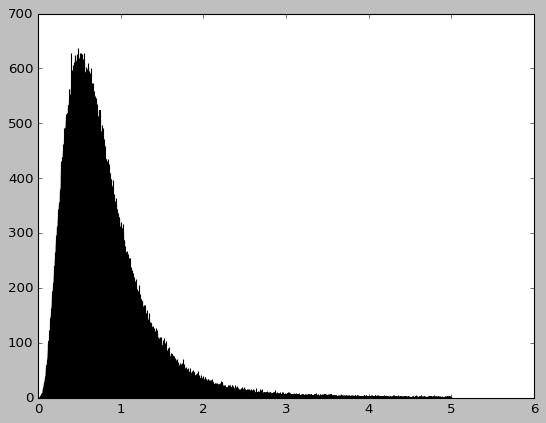

In [84]:
plt.style.use('default')
bins = np.linspace(0,5,10001)
plt.hist(sigaeloss_bkg,bins=bins)
plt.show()

In [30]:
mass_bb.shape

(1000100,)

In [31]:
############### DEFAULT CUT BB1 ##############
sigae_wp = .65
bkgae_wp = 2

In [ ]:
############### DEFAULT CUT BB2 ##############
sigae_wp = .8
bkgae_wp = 1.8

In [ ]:
############### DEFAULT CUT BB3 ##############
sigae_wp = .66
bkgae_wp = 1.7

In [ ]:
###CUT 1% Diluted, 1000 signal events
sigae_wp = 2
bkgae_wp = 1.5

In [69]:
###CUT 1% Diluted, 1000 signal events
sigae_wp = 2
bkgae_wp = 1.5

In [70]:
index_bb = np.where((bkgaeloss_bb>bkgae_wp)&(sigaeloss_bb<sigae_wp))[0]
index_bkg = np.where((bkgaeloss_bkg>bkgae_wp)&(sigaeloss_bkg<sigae_wp))[0]

print(index_bb.shape[0])
print(index_bkg.shape[0])

31919
32369


In [71]:
bins = np.linspace(1000,8000,71,dtype=np.int16)
print(bins)

[1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300
 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700
 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100
 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500
 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900
 8000]


In [72]:
mass_bb[index_bb].shape

(31919,)

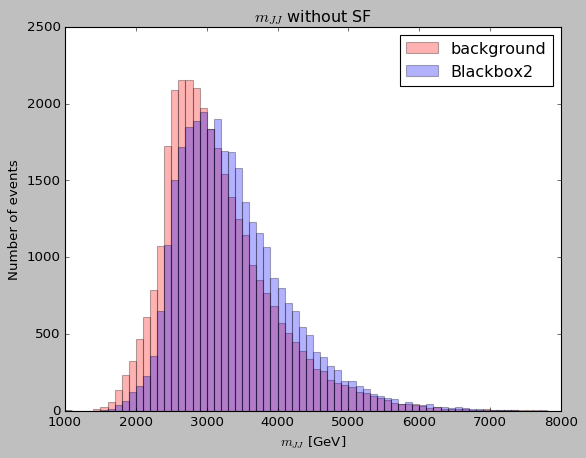

In [73]:
#### Without Scalefactor
#PLOT FOR BLACK BOX 1 with REALNVP
plt.style.use('default')
bins = np.linspace(1000,8000,71)
bkg_hist = plt.hist(mass_bkg[index_bkg],bins=bins,alpha=0.3,color='r',label='background');
obs_hist = plt.hist(mass_bb[index_bb],bins=bins,alpha=0.3,color='b',label='Blackbox2');
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.title('$m_{JJ}$ without SF')
plt.show()
#plt.axvline(x=38238
#plt.savefig("/data/t3home000/spark/LHCOlympics/plots/NEW_BB3_mjj_massratios_noscalefactor_1dot8_0dot5.png")
# plt.savefig("AnalysisBB2/bkgAEcut_mjj_noscalefactor.png")

# Start Generating Shapes for the Fit

In [ ]:
def smear(iVar,iDataHist,iScale=0.1):
    lDM     = r.RooRealVar("Xshift","Xshift", 1.,0.,200.)
    lVar    = iDataHist.createHistogram("x").GetMean()
    lInt    = iDataHist.createHistogram("x").Integral()
    lShift  = r.RooFormulaVar("Xsmear","("+iVar.GetName()+"-"+str(lVar)+")/Xshift+"+str(lVar),r.RooArgList(iVar,lDM))  
    lHPdf   = r.RooHistPdf(iDataHist.GetName()+"S",iDataHist.GetName()+"S", r.RooArgList(lShift),r.RooArgList(iVar),iDataHist,0)
    lDM.setVal(1.+iScale)
    lHUp = lHPdf.createHistogram("x")
    lHUp.Scale(lInt)
    lUp = r.RooDataHist(iDataHist.GetName()+"_smearUp",iDataHist.GetName()+"_smearUp", r.RooArgList(iVar),lHUp)    
    lDM.setVal(1.-iScale)
    lHDown = lHPdf.createHistogram("x")
    lHDown.Scale(lInt)
    lDown  = r.RooDataHist(iDataHist.GetName()+"_smearDown",iDataHist.GetName()+"_smearDown", r.RooArgList(iVar),lHDown)
    return [lUp,lDown] 

In [ ]:
# Observable
x = r.RooRealVar("x","m_{JJ} [GeV]", 1000,8000)

In [ ]:
mygaus = r.TF1("mygaus","TMath::Gaus(x,4100,300)",1000,8000)
smear_up = r.TF1("smear_up","TMath::Gaus(x,4100,80)",1000,8000)
smear_down = r.TF1("smear_down","TMath::Gaus(x,4100,600)",1000,8000)
scale_up = r.TF1("scale_up","TMath::Gaus(x,4700,300)",1000,8000)
scale_down = r.TF1("scale_down","TMath::Gaus(x,3500,300)",1000,8000)


roothist_sig = r.TH1F('signal','signal',70,1000,8000)
roothist_scup = r.TH1F('signal_scaleUp','signal',70,1000,8000)
roothist_scdown = r.TH1F('signal_scaleDown','signal',70,1000,8000)
roothist_smup = r.TH1F('signal_smearUp','signal',70,1000,8000)
roothist_smdown = r.TH1F('signal_smearDown','signal',70,1000,8000)

roothist_sig.FillRandom("mygaus",1000)
roothist_scup.FillRandom('scale_up',1000)
roothist_scdown.FillRandom('scale_down',1000)
roothist_smup.FillRandom('smear_up',1000)
roothist_smdown.FillRandom('smear_down',1000)


In [ ]:
for i in range(0,70):
    roothist_obs.SetBinContent(i+1,obs_hist[0][i])
    roothist_bkg.SetBinContent(i+1,bkg_hist[0][i])

In [ ]:
iDataHist = r.RooDataHist("signal","signal",r.RooArgList(x),roothist_sig)

In [ ]:
f = r.TFile.Open("shapes-blackbox2-TH1.root",'recreate')
roothist_sig.Write()
roothist_obs.Write()
roothist_bkg.Write()
roothist_scup.Write()
roothist_scdown.Write()
roothist_smup.Write()
roothist_smdown.Write()

f.Close()

In [ ]:
c11 = r.TCanvas("myCanvasName","The Canvas Title",800,600)
roothist_sig.Draw()
roothist_scup.SetLineColor(r.kRed)
roothist_scup.Draw('same')

roothist_scdown.SetLineColor(r.kBlue)
roothist_scdown.Draw('same')
c11.Draw()

In [ ]:
c11 = r.TCanvas("myCanvasName","The Canvas Title",800,600)
roothist_sig.Draw()
roothist_scup.Draw('same')
roothist_scdown.Draw('same')
c11.Draw()

In [ ]:
f = r.TFile.Open("shapes-blackbox1-TH1.root",'read')
f.ls()
f.Close()

In [ ]:
ObsHist = r.RooDataHist("data_obs","data_obs",r.RooArgList(x),roothist_obs)
BkgHist = r.RooDataHist("purebkg","purebkg",r.RooArgList(x),roothist_bkg)

In [ ]:
f = r.TFile.Open("shapes-blackbox1-TH1.root",'recreate')
ObsHist.Write()
BkgHist.Write()
iDataHist.Write()

f.Close()

In [ ]:
iDataHist = r.RooDataHist("signal","signal",r.RooArgList(x),roothist_sig)

In [ ]:
smear_up, smear_down = smear(x,iDataHist,0.1)

In [ ]:
def shift(iVar,iDataHist,iShift=5.):
    lInt    = iDataHist.createHistogram("x").Integral()
    lDM     = r.RooRealVar   ("Xdm","Xdm", 0.,-300,300)
    lShift  = r.RooFormulaVar("Xshift",iVar.GetName()+"-Xdm",r.RooArgList(iVar,lDM))
    print(lShift)
    lSPdf   = r.RooHistPdf(iDataHist.GetName()+"P",iDataHist.GetName()+"P", r.RooArgList(lShift),r.RooArgList(iVar),iDataHist,0)
    lDM.setVal(iShift)
    lHUp   = lSPdf.createHistogram("x")
    lHUp.Scale(lInt)
    lUp    = r.RooDataHist(iDataHist.GetName()+"_scaleUp",iDataHist.GetName()+"_scaleUp", r.RooArgList(iVar),lHUp)
    lDM.setVal(-iShift)
    lHDown = lSPdf.createHistogram("x")
    lHDown.Scale(lInt)
    lDown  = r.RooDataHist(iDataHist.GetName()+"_scaleDown",iDataHist.GetName()+"_scaleDown", r.RooArgList(iVar),lHDown)
    return (lUp,lDown)

In [ ]:
shift_up, shift_down = shift(x,iDataHist,20.0)

In [ ]:
xframe = x.frame()

In [ ]:
a = smear_up.generateBinned("x",100)

In [ ]:
print(h_)

In [ ]:
c11 = r.TCanvas("myCanvasName","The Canvas Title",800,600)
roothist_sig.Draw()
c11.Draw()

In [ ]:
#c.plotOn(xframe,r.RooFit.DrawOption("*"),r.RooFit.DataError(0))
smear_up.plotOn(xframe,r.RooFit.MarkerColor(9),r.RooFit.DataError(0))
iDataHist.plotOn(xframe,r.RooFit.MarkerColor(r.kBlack),r.RooFit.DataError(0))
smear_down.plotOn(xframe,r.RooFit.MarkerColor(8),r.RooFit.DataError(0))
c11 = r.TCanvas("myCanvasName","The Canvas Title",800,600)
#model.plotOn(mjjframe, r.RooFit.Components("background"), r.RooFit.LineStyle(r.kDashed))
xframe.Draw()

c11.Draw()

In [ ]:
#c.plotOn(xframe,r.RooFit.DrawOption("*"),r.RooFit.DataError(0))
smear_up.plotOn(xframe,r.RooFit.MarkerColor(9),r.RooFit.DataError(0))
iDataHist.plotOn(xframe,r.RooFit.MarkerColor(r.kBlack),r.RooFit.DataError(0))
smear_down.plotOn(xframe,r.RooFit.MarkerColor(8),r.RooFit.DataError(0))
c11 = r.TCanvas("myCanvasName","The Canvas Title",800,600)
#model.plotOn(mjjframe, r.RooFit.Components("background"), r.RooFit.LineStyle(r.kDashed))
xframe.Draw()

c11.Draw()

In [ ]:
roothist_obs = r.TH1F('data_obs','data_obs',70,1000,8000)
roothist_bkg = r.TH1F('purebkg','purebkg',70,1000,8000)

In [ ]:
for i in range(0,70):
    roothist_obs.SetBinContent(i+1,obs_hist[0][i])
    roothist_bkg.SetBinContent(i+1,bkg_hist[0][i])

In [ ]:
ObsHist = r.RooDataHist("data_obs","data_obs",r.RooArgList(x),roothist_obs)
BkgHist = r.RooDataHist("purebkg","purebkg",r.RooArgList(x),roothist_bkg)

In [ ]:
f = r.TFile.Open("shapes-blackbox1-TH1.root",'recreate')
roothist_sig.Write()
roothist_bkg.Write()
roothist_obs.Write()
smear_up.Write()
smear_down.Write()
shift_up.Write()
shift_down.Write()
f.Close()

In [ ]:
f.Close()

In [ ]:
f = r.TFile.Open("shapes-blackbox1-TH1.root",'read')

In [ ]:
f.ls()

In [ ]:
f.Close()

In [ ]:
c = r.TCanvas("myCanvasName","The Canvas Title",800,600)
roothist_bkg.Draw()
c.Draw()

In [ ]:
function_gaus = r.TF1("mygaus","TMath::Gaus(x,3823,400)",1000,8000)
roothist_sig = r.TH1F('signal','signal',70,1000,8000)
roothist_sig.FillRandom("mygaus",10000)

In [ ]:
lDM   = rt.RooRealVar("Xshift","Xshift", 1.,0.,2.)
x     = rt.RooRealVar("x" ,"x", 0.0   ,1000  ,8000)
mean  = rt.RooRealVar("mean",'mean',3823,1000,8000)
sigma = rt.RooRealVar("sigma",'sigma',200,0,500)

In [ ]:
lDM     = rt.RooRealVar("Xshift","Xshift", 1.,0.,2.)
lVar    = iDataHist.createHistogram("x").GetMean()
lInt    = iDataHist.createHistogram("x").Integral()

In [ ]:
iVar = rt.RooRealVar("x","x",3600,1000,8000)
lShift  = rt.RooFormulaVar("Xsmear","("+iVar.GetName()+"-"+str(lVar)+")/Xshift+"+str(lVar),rt.RooArgList(iVar,lDM))  

In [ ]:
def smear(iVar,iDataHist,iScale=0.1):
    lDM     = rt.RooRealVar("Xshift","Xshift", 1.,0.,2.)
    lVar    = iDataHist.createHistogram("x").GetMean()
    lInt    = iDataHist.createHistogram("x").Integral()
    lShift  = r.RooFormulaVar("Xsmear","("+iVar.GetName()+"-"+str(lVar)+")/Xshift+"+str(lVar),r.RooArgList(iVar,lDM))  
    if f2D:
        lHPdf   = r.RooHistPdf(iDataHist.GetName()+"S",iDataHist.GetName()+"S", r.RooArgList(lShift,fVars[1]),r.RooArgList(iVar,fVars[1]),iDataHist,0)
    else:
        lHPdf   = r.RooHistPdf(iDataHist.GetName()+"S",iDataHist.GetName()+"S", r.RooArgList(lShift),r.RooArgList(iVar),iDataHist,0)
    lDM.setVal(1.+iScale)
    lHUp = lHPdf.createHistogram("x")
    lHUp.Scale(lInt)
    lUp = r.RooDataHist(iDataHist.GetName()+"_smearUp",iDataHist.GetName()+"_smearUp", r.RooArgList(iVar),lHUp)    
    lDM.setVal(1.-iScale)
    lHDown = lHPdf.createHistogram("x")
    lHDown.Scale(lInt)
    lDown  = r.RooDataHist(iDataHist.GetName()+"_smearDown",iDataHist.GetName()+"_smearDown", r.RooArgList(iVar),lHDown)
    return [lUp,lDown] 